# Modeling Non-Stationary Data: The ARIMA Model

* The need for ARIMA 
  * ARMA models perform subpar when computing non-stationary data 
  * ARIMA = Autoregressive Integrated Moving Average Model
  * "Integrated" accounts for the number of non-seasonal differences we need to examine to establish stationarity 
  * Such a model targets the difference between the values in period T and the one preceding it
  * It essentially estimates the jumps between prices rather than the actual prices
  * In a sense it assumes a sort of random walk element to our data set and models the differences from one period to the next instead of the values themselves 
  * The purpose behind this complication of the model is to ensure staionarity no matter the underlying data. 
  * For some types of data including a single factor of integration is enough to reach stationarity. 
    * transforming prices into price returns is a way of brute integration 

* ARIMA notation

  * ARIMA(p, d, q); three orders to define
    * p: AR lags
    * q: MA lags 
    * d: integration order 
  * d: Integration
    * The number of times we need to integrate the time-series to ensure stationarity 
    * ARIMA(p, 0, q) = ARMA(p, q)
    * ARIMA(0, 0, q) = AR(q)
    * ARIMA(p, 0, 0) = MA(q)

* ARMA intuition 

  * "accounting for the non-seasonal difference between periods  to establish stationarity"
  * Hence, even the AR components in the model should be price differences rather than prices 
  * In a sense, we are integrating D many times to construct a new time series and then fitting said series into an ARIMA(p, q) model. 

* Equation

  * ARIMA(1, 1, 1):

    * $$
      \Delta P_t = c + \varphi_1\Delta P_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t
      $$

    * $P_t, P_{t-1}$: Values in the current period and 1 period ago 

    * $\epsilon_t, \epsilon_{t-1}$: Error terms for the same two periods 

    * $c$: Baseline constant factor 

    * $\varphi_1$: What part of the value last period is relevant in explaining the current one 

    * $\theta_1$: What part of the error last period is relevant in explaining the currnet value

    * $\Delta P_t = P_t - P_{t-1}$

  * ARIMA(p, d, q) is an ARMA(p, q) model for a newly generated time-series

* Process

  * Cannot use ACF or PACF directly using the raw data 
  * Instead, examine the ACF of the residuals 
  * Note that we will lose a single observation for any integration 

* Why we would avoid using ARIMA for staionary data 

    * ARIMA models are more computationally expensive than regular ARMA models
      * e.g. generate every layer of integration one by one (p -> dP -> d'P -> d''P)
      * e.g. also try to fit the new data using any of the regular ARMA models 
    * Data attrition 
      * We lose observations because of the conversion 
      * The more unnecessary layers we add, the more our model suffers 
    * Values become small for each differntiation 
      * The margin of something being significant or insignificant becomes really narrow
      * This leas models to fail to converge 
      * It also causes numerical instability (computer approximates a small number to 0, losing information)
    * Hard to interprete 
      * e.g. ARIMA(p, 4, q). The coefficients would be for 4th differentiate of the original time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Importing the data and pre-processing

In [2]:
raw_csv_data = pd.read_csv('../data/Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse

In [4]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

In [5]:
df['returns'] = df.market_value.pct_change(1) * 100

# LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF=1):
    # DF: degrees of freedom
    
    # log likelihood
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    
    # test statistic
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

# ARIMA(1, 1, 1) 

In [7]:
df.market_value.head()

date
1994-01-07    3445.98
1994-01-10    3440.58
1994-01-11    3413.77
1994-01-12    3372.02
1994-01-13    3360.01
Freq: B, Name: market_value, dtype: float64

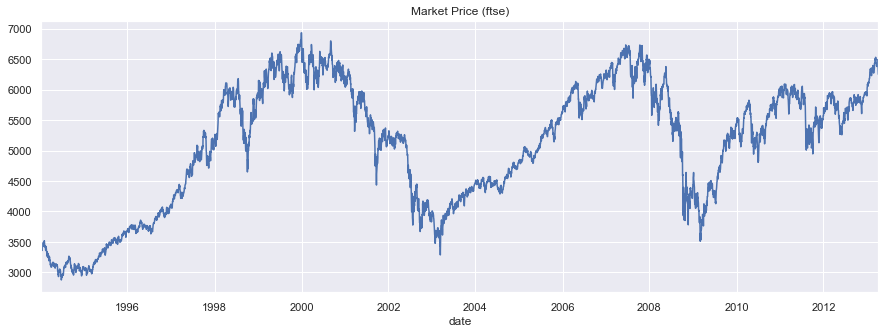

In [8]:
df.market_value.plot(figsize=(15, 5))
plt.title("Market Price (ftse)")
plt.show()

In [9]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Tue, 09 Feb 2021   AIC                          55215.333
Time:                        22:58:38   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.651      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.377      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

Note that there are only two coefficients to estimate; one for AR and the other for MA. The integration part of the ARIMA order is for transforming the underlying data, not to estimate.
$$ \text{ARIMA}(1, 1, 1) = \Delta P_t = c + \varphi_1\Delta P_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t$$

The p-value for the constant is 0.407, suggesting that it is not significantly different from 0. So far, constant was zero for returns, and non-zero for prices. This suggests that ARIMA model with prices is close to ARMA with returns. 

# Residuals of the ARIMA(1, 1, 1)

In [10]:
df['res_ar_1_i_1_ma_1']

KeyError: 'res_ar_1_i_1_ma_1'

In [ ]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1, 1, 1)")
plt.show()

The ACF failed to compute due to the missing value at the first element. Since the ACF starts by trying to compare elements from the very first one going foward, a missing value at the very beginning causes it to break. The easiest solution to this is to remove the first element. 

In [ ]:
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1, 1, 1)")
plt.show()

The third and forth lags seems significant. Incorporating thses lags into our model might significantly improve the model performance.

# Higher-Lag ARIMA Models

We will avoid doing all the unncessary trial and error steps we did for the ARMA model.

Based on the fact that the third and fourth lags are significant, it leads us to experiment all from ARIMA(1, 1, 1) to ARIMA(4, 1, 4). Among those 15 models, these are the 5 models that yield all significant coefficients at the 5 percent level:
- ARIMA(1, 1, 2)
- ARIMA(1, 1, 3)
- ARIMA(2, 1, 1)
- ARIMA(3, 1, 2)
- ARIMA(3, 1, 2)


In [ ]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)


As always, make sure to provide enough starting AR lags for each model to allow the execution of the fit method without crashing by simply giving a numeric value greater than the AR order. We do that only for ARIMA(3,1,2) but remember to account for them with more complicated models. 

In [ ]:
print("ARIMA(1, 1, 1): LL = ", results_ar_1_i_1_ma_1.llf, "\tAIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1, 1, 2): LL = ", results_ar_1_i_1_ma_2.llf, "\tAIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1, 1, 3): LL = ", results_ar_1_i_1_ma_3.llf, "\tAIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2, 1, 1): LL = ", results_ar_2_i_1_ma_1.llf, "\tAIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3, 1, 1): LL = ", results_ar_3_i_1_ma_1.llf, "\tAIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3, 1, 2): LL = ", results_ar_3_i_1_ma_2.llf, "\tAIC = ", results_ar_3_i_1_ma_2.aic)


This result shows that ARIMA(1, 1, 3) yields the highest log likelihood and the lowest AIC. However, since ARIMA(1, 1, 1) and ARIMA(1, 1, 2) are nested of ARIMA(1, 1, 3), we need to run the LLR test to see if ARIMA(1, 1, 3) significantly outperforms them. 

In [ ]:
print("ARIMA(1, 1, 2) vs ARIMA(1, 1, 3):", LLR_test(model_ar_1_i_1_ma_2, model_ar_1_i_1_ma_3))
print("ARIMA(1, 1, 1) vs ARIMA(1, 1, 3):", LLR_test(model_ar_1_i_1_ma_1, model_ar_1_i_1_ma_3, DF=2))


The zero indicates that the higher complexity is necessary. So, looks like ARIMA(1, 1, 3) is the best model so far.

# Residuals of ARIMA(1, 1, 3)

In [ ]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero=False, lags=40)
plt.title("ACF for Residuals of ARIMA(1, 1, 3)")
plt.show()

There seems to be a pattern at the 6th lag. Therefore, we need to examine models that include 6th lag - from ARIMA(1, 1, 1) to ARIMA(6, 1, 6). There are 6 x 6 = 36 models to check. After going through them, there are only two models that yielded significant values. 
- ARIMA(6, 1, 3)
- ARIMA(5, 1, 1)

Note that previously, we saw that ARMA(5, 1) was our preferred choice for price returns. so the fact that ARIMA(5, 1, 1) is a good estimator isn't all that surprising. 

In [ ]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit()
model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit()

In [ ]:
print("ARIMA(1, 1, 3): LL = ", results_ar_1_i_1_ma_3.llf, "\tAIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5, 1, 1): LL = ", results_ar_5_i_1_ma_1.llf, "\tAIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(6, 1, 3): LL = ", results_ar_6_i_1_ma_3.llf, "\tAIC = ", results_ar_6_i_1_ma_3.aic)


Looks like ARIMA(6, 1, 3) has the highest log likelihood and the lowest AIC so it is the best estimator. Is the additional complexity worth it?

In [ ]:
print("ARIMA(1, 1, 3) vs ARIMA(6, 1, 3):", LLR_test(model_ar_1_i_1_ma_3, model_ar_6_i_1_ma_3, DF=5))
print("ARIMA(5, 1, 1) vs ARIMA(6, 1, 3):", LLR_test(model_ar_5_i_1_ma_1, model_ar_6_i_1_ma_3, DF=3))


In [ ]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero=False, lags=40)
plt.title("ACF for Residuals of ARIMA(5, 1, 1)")
plt.show()

We can see none of the first 15 residuals have significant coefficients. This is great because we capture the 6th lag effect without directly incorporating the lag. We see some significant coefficients many lags into the past but we know that the further back the time we go, the less relevant the values become. 

If we include 35 lags the residuals will be white noise. It's important to remember that we want this model to be able to predict other time series data as well. Taking 35 lags will result in the model parameters become too dependent on the data set which will in turn take away from its predictive power. 

So, we decide ARIMA(5, 1, 1) is the best fitting model.

# Higher Levels of Integration

We only rely on integration, when our time-series doesn't come from a stationary process. If a single layer of integration can accomplishes this, any additional integrations are unnecessary. How do we know if the integrated data set is stationary? 1) Manually create an integrated version of the original time-sereis and 2) use the Augmented Dickey-Fuller test. 

ARIMA(1, 1, 1) if prices is equivalent to ARMA(1, 1) of delta prices  
ARIMA(1, 0, 1) is equipvalent to ARMA(1, 1)

In [ ]:
df['delta_prices'] = df.market_value.diff(1)

In [ ]:
# check ARIMA(1, 0, 1) of delta to see if 
# it is equivalent of ARIMA(1, 1, 1) of prices
model_delta_ar_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1, 0, 1))
results_delta_ar_1_ma_1 = model_delta_ar_1_ma_1.fit()
results_delta_ar_1_ma_1.summary()

The coefficients and the p values are equivalent with those from ARIMA(1, 1, 1) of prices.

In [ ]:
sts.adfuller(df.delta_prices[1:])

This verifies stationarity, and it means we do not need additional integration.